# HEART RATE ESTIMATION

In [1]:
######  LIBRARIES  #######
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
from scipy import linalg as la
from scipy.fft import fft, ifft
from scipy.signal import welch, butter, filtfilt, find_peaks
import pywt

**Data preparation:**

1. Load the txt file and select only the columns you are interesting in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )

In [2]:
###### IMPORT DATA #######
file_name = "center_sternum.txt"

# creation of a DataFrame containing the whole dataset
df_sternum = pd.DataFrame(pd.read_csv(file_name, sep = "\t", header = 0))

# select just the column of interest
df_sternum = df_sternum.iloc[:,[1,3,4,5,6,7,8]]

# recover the samples frequency
freq = df_sternum['Log Freq'][0]

# create the time vector
time = np.arange(0, len(df_sternum)* 1/freq, 1/freq)

# create the AccX, AccY, AccZ ,GyroX, GyroY, GyroZ vectors
accX, accY, accZ = df_sternum['AccX'][:], df_sternum['AccY'][:], df_sternum['AccZ'][:]
gyroX,gyroY,gyroZ = df_sternum['GyroX'][:], df_sternum['GyroY'][:], df_sternum['GyroZ'][:]

# insert time column
df_sternum.insert(1, "Time", time)

# print data
df_sternum.head


<bound method NDFrame.head of        Log Freq    Time     AccX     AccY    AccZ      GyroX      GyroY  \
0           200   0.000  947.086  435.662  70.638  -6.824428 -14.244280   
1           200   0.005  969.168  387.777  88.877   6.183206 -12.290080   
2           200   0.010  989.603  380.335  78.751  11.709920  -4.961832   
3           200   0.015  954.894  418.033  88.328  17.877860   2.519084   
4           200   0.020  972.096  427.732  99.857  25.221370   5.404580   
...         ...     ...      ...      ...     ...        ...        ...   
16501       200  82.505  958.493  291.092 -54.290   1.664122   2.305344   
16502       200  82.510  954.650  288.042 -49.654   1.480916   2.488550   
16503       200  82.515  967.338  290.482 -63.867   1.114504   3.374046   
16504       200  82.520  965.630  300.852 -56.242   0.702290   3.664122   
16505       200  82.525  959.957  298.473 -55.998   0.290076   4.061069   

          GyroZ  
0      1.404580  
1     -7.969466  
2     -7.450382

2. Plot selected data in function of time and choose a properly time window over which to perform the analysis. Pay attention on time rappresentation and the measurament unit.

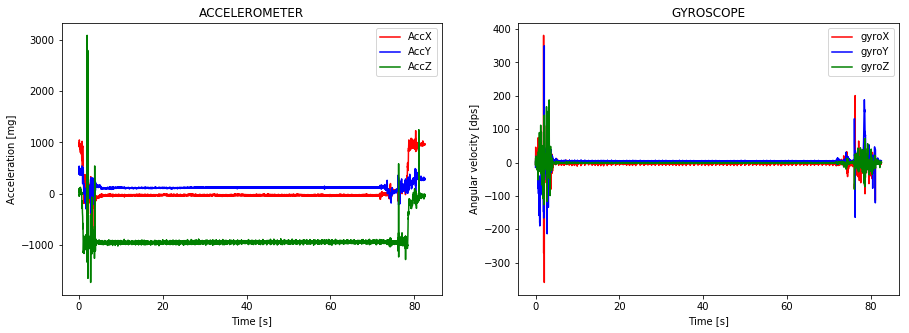

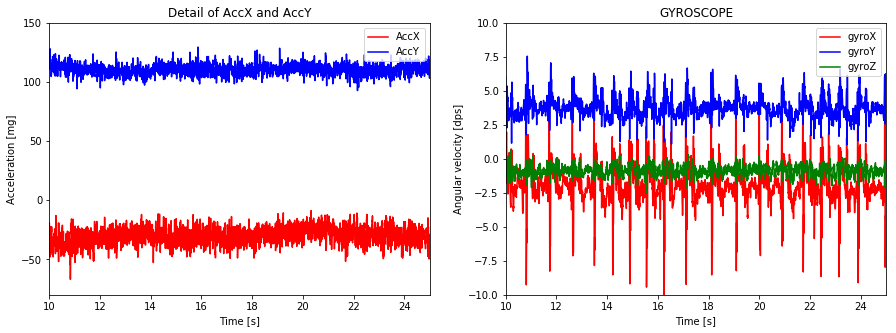

In [3]:
##### PLOT OF THE DATA #####

# create the subplots 
figure, axis = plt.subplots(1,2, figsize = (15,5))

# plot the accelerometer's data
axis[0].plot(time,accX,'r',label = 'AccX')
axis[0].plot(time,accY,'b',label = 'AccY')
axis[0].plot(time,accZ,'g',label = 'AccZ')
axis[0].set_xlabel('Time [s]')
axis[0].set_ylabel('Acceleration [mg]')
axis[0].set_title('ACCELEROMETER')
axis[0].legend(loc = 1)

#plot the gyroscope's data
axis[1].plot(time,gyroX,'r',label = 'gyroX')
axis[1].plot(time,gyroY,'b',label = 'gyroY')
axis[1].plot(time,gyroZ,'g',label = 'gyroZ')
axis[1].set_xlabel('Time [s]')
axis[1].set_ylabel('Angular velocity [dps]')
axis[1].set_title('GYROSCOPE')
axis[1].legend(loc = 1)

# create the subplots for a detail of the previous ones
figure, axis = plt.subplots(1,2, figsize = (15,5))

# plot a detail of the accelerometer plot
axis[0].plot(time,accX,'r',label = 'AccX')
axis[0].plot(time,accY,'b',label = 'AccY')
axis[0].set_xlabel('Time [s]')
axis[0].set_ylabel('Acceleration [mg]')
axis[0].set_title('Detail of AccX and AccY')
axis[0].set_ylim([-80,150])
axis[0].set_xlim([10,25])
axis[0].legend(loc = 1)

# plot a detail of the gyroscope plot
axis[1].plot(time,gyroX,'r',label = 'gyroX')
axis[1].plot(time,gyroY,'b',label = 'gyroY')
axis[1].plot(time,gyroZ,'g',label = 'gyroZ')
axis[1].set_xlabel('Time [s]')
axis[1].set_ylabel('Angular velocity [dps]')
axis[1].set_title('GYROSCOPE')
axis[1].set_ylim([-10,10])
axis[1].set_xlim([10,25])
axis[1].legend(loc = 1)


3. In order to make an appropiate work, decide if take care about some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.  


In [4]:
# select interval of interest
df_sternum = df_sternum[(df_sternum['Time'] >= 10) & (df_sternum['Time'] < 70)]

# update accX, accY, accZ, gyroX, gyroY, gyroZ
time = np.arange(0, len(df_sternum)* 1/freq, 1/freq)
accX, accY, accZ = df_sternum['AccX'][:], df_sternum['AccY'][:], df_sternum['AccZ'][:]
gyroX, gyroY, gyroZ = df_sternum['GyroX'][:], df_sternum['GyroY'][:], df_sternum['GyroZ'][:]


**PCA for Accelerometer**

Text(0, 0.5, 'AccZ')

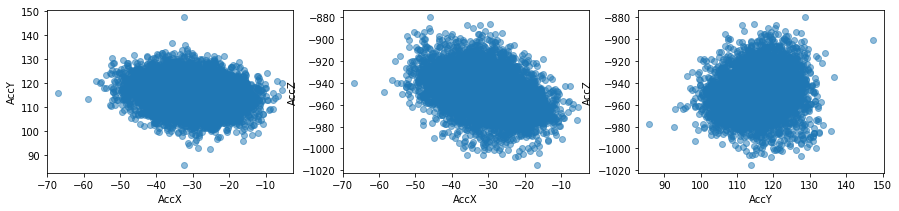

In [5]:
# create the matrix for the PCA technique, in the rows there are the AccX, AccY, AccZ measurments, and each 
# column represents a data sample
X_acc = np.array([accX, accY, accZ])

figure, axis = plt.subplots(1,3, figsize = (15,3))
axis[0].scatter(X_acc[0,:], X_acc[1,:], alpha=0.5)
axis[0].set_xlabel('AccX')
axis[0].set_ylabel('AccY')
axis[1].scatter(X_acc[0,:], X_acc[2,:], alpha=0.5)
axis[1].set_xlabel('AccX')
axis[1].set_ylabel('AccZ')
axis[2].scatter(X_acc[1,:], X_acc[2,:], alpha=0.5)
axis[2].set_xlabel('AccY')
axis[2].set_ylabel('AccZ')


# da sistemareeee
#scale_factor = 0.01
#axis[0].plot([0,0.1*l[0]*V.T[0,0]],[0,0.1*l[0]*V.T[0,1]],'r-', lw=2)
#axis[0].plot([0,l[1]*V.T[1,0]],[0,l[1]*V.T[1,1]],'r-')

#axis[1].plot([0,0.1*scale_factor*l[0]*V.T[0,0]],[0,0.1*scale_factor*l[0]*V.T[0,2]],'r-', lw=2)
#axis[1].plot([0,l[2]*V.T[2,0]],[0,l[2]*V.T[2,2]],'r-')

#axis[2].plot([0,0.5*l[1]*V.T[1,1]],[0,0.5*l[1]*V.T[1,2]],'r-', lw=2)
#axis[2].plot([0,0.5*l[2]*V.T[2,1]],[0,0.5*l[2]*V.T[2,2]],'r-')

In [6]:
# compute the mean of X and subtract it to obtain a zero main matrix X
X_acc = X_acc - X_acc.mean()

# calculate the eigenvalues and eigenvectors of the covariance matrix and compute the covarinace matrix of the new 
# matrix 
l, V = la.eig(np.cov(X_acc))
#P = V.T
#Cy = P.dot(np.cov(X)).dot(P.T)
Cy = np.diag(np.round(np.real(l),2))
print(Cy, "\n")


# estimate if reduce dimensionality is convenient 
print("Trace of the original data matrix: " , np.round(np.cov(X_acc).trace(),2))
print("Trace of the data matrix after the changes of base: ", np.round(Cy.trace(),2), "\n")

print("Fraction of the total variability keeping only the first principal component: ", np.round(100*(Cy[0,0])/Cy.trace()),"%")
print("Fraction of the total variability keeping only the first principal component: ", np.round(100*(Cy[0,0]+Cy[1,1])/Cy.trace()),"%")
print("Fraction of the total variability keeping only the first principal component: ", np.round(100*(Cy[1,1]+Cy[2,2])/Cy.trace()),"%")

# as consequence of the PCA technique keeping the two principal components for the Accelerometer is better

P = V[:,0:2] #the eigenvectors are in the columns of V

Y_acc = P.T.dot(X_acc) # new data according to PCA result

[[218.52   0.     0.  ]
 [  0.    39.8    0.  ]
 [  0.     0.    26.45]] 

Trace of the original data matrix:  284.76
Trace of the data matrix after the changes of base:  284.77 

Fraction of the total variability keeping only the first principal component:  77.0 %
Fraction of the total variability keeping only the first principal component:  91.0 %
Fraction of the total variability keeping only the first principal component:  23.0 %


**PCA for Gyroscope**

Text(0, 0.5, 'AccZ')

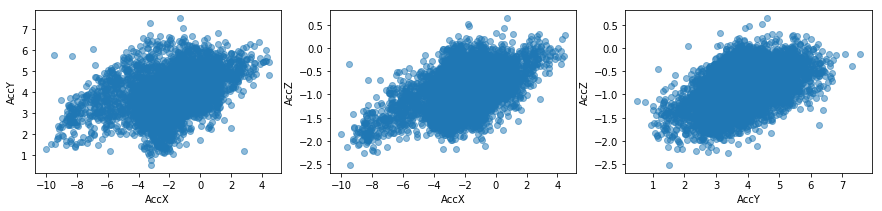

In [7]:
X_gyro = np.array([gyroX, gyroY, gyroZ]) 

figure, axis = plt.subplots(1,3, figsize = (15,3))
axis[0].scatter(X_gyro[0,:], X_gyro[1,:], alpha=0.5)
axis[0].set_xlabel('AccX')
axis[0].set_ylabel('AccY')
axis[1].scatter(X_gyro[0,:], X_gyro[2,:], alpha=0.5)
axis[1].set_xlabel('AccX')
axis[1].set_ylabel('AccZ')
axis[2].scatter(X_gyro[1,:], X_gyro[2,:], alpha=0.5)
axis[2].set_xlabel('AccY')
axis[2].set_ylabel('AccZ')


In [8]:
#compute the mean of X and subtract it to obtain a zero main matrix X
X_gyro = X_gyro - X_gyro.mean()

# calculate the eigenvalues and eigenvectors of the covariance matrix and compute the covarinace matrix of the new 
# matrix 
l, V = la.eig(np.cov(X_gyro))
#P = V.T
#Cy = P.dot(np.cov(X)).dot(P.T)
Cy = np.diag(np.round(np.real(l),2))
print(Cy, "\n")


# estimate if reduce dimensionality is convenient 
print("Trace of the original data matrix: " , np.round(np.cov(X_gyro).trace(),2))
print("Trace of the data matrix after the changes of base: ", np.round(Cy.trace(),2), "\n")

print("Fraction of the total variability keeping only the first principal component: ", np.round(100*(Cy[0,0])/Cy.trace()),"%")
print("Fraction of the total variability keeping only the first principal component: ", np.round(100*(Cy[0,0]+Cy[1,1])/Cy.trace()),"%")
print("Fraction of the total variability keeping only the first principal component: ", np.round(100*(Cy[1,1]+Cy[2,2])/Cy.trace()),"%")

# as consequence of the PCA technique keeping the two principal components for the Gyroscope is better
P = V[:,0:2] #the eigenvectors are in the columns of V

Y_gyro = P.T.dot(X_gyro) # new data according to PCA result

[[2.12 0.   0.  ]
 [0.   0.42 0.  ]
 [0.   0.   0.1 ]] 

Trace of the original data matrix:  2.64
Trace of the data matrix after the changes of base:  2.64 

Fraction of the total variability keeping only the first principal component:  80.0 %
Fraction of the total variability keeping only the first principal component:  96.0 %
Fraction of the total variability keeping only the first principal component:  20.0 %


**Time and frequency analysis:**

1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.


In [9]:
# compute statistics
df_stat = df_sternum.describe()
df_stat = df_stat.rename(columns={"Time": "Time [s]", "AccX": "AccX [mg]", "AccY": "AccY [mg]", "AccZ": "AccZ [mg]", "GyroX": "GyroX [rad/s]", "GyroY": "GyroY [rad/s]", "GyroZ": "GyroZ [rad/s]"})
df_stat.round(1)
stat = df_stat.iloc[:,1:].round(1)
stat


,Time [s],AccX [mg],AccY [mg],AccZ [mg],GyroX [rad/s],GyroY [rad/s],GyroZ [rad/s]
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,40.0,-30.7,115.6,-949.1,-2.1,3.7,-0.9
std,17.3,7.0,5.3,14.4,1.4,0.7,0.4
min,10.0,-66.9,85.8,-1015.5,-10.0,0.5,-2.5
25%,25.0,-35.3,112.1,-957.6,-2.7,3.3,-1.1
50%,40.0,-30.6,115.7,-949.5,-2.2,3.6,-0.9
75%,55.0,-26.0,119.1,-941.3,-1.5,4.0,-0.6
max,70.0,-5.4,147.4,-879.7,4.5,7.6,0.6


2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use this step in order to properly design the filters in the following step. 


12000


(0, 2)

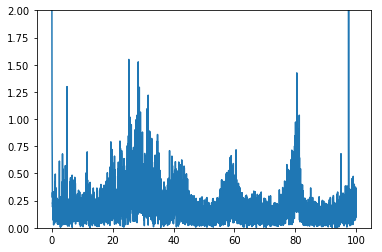

In [10]:
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)      
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])     
    return f_values, fft_values

def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

N = df_sternum.shape[0]
print(N)
T = 1/freq   
f_s = freq   

f_values, fft_values = get_fft_values(np.array(accZ), T, N, f_s)
plt.plot(f_values, fft_values)
plt.ylim(0, 2)



(0, 11)

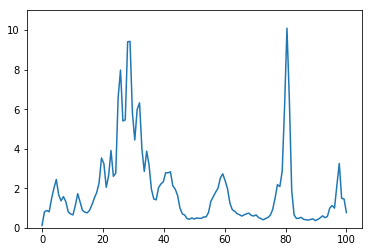

In [11]:
f_values_psd, psd_values = get_psd_values(np.array(accZ), T, N, f_s)
plt.plot(f_values_psd, psd_values)
plt.ylim(0, 11)


**Filter:**
    
Implement your own filter, trying to extrapolate heart rate signal. Hint:
    
    (a) Directly from Fourier Analysis, antitrasform data looking for the most interesting frequency band.
    
    (b) Choose the appropriate Lowpass/Bandpass/Highpass filter.
    
    (c) Wavelet trasform (a powerfull instrument that make a time and frequency analysis of signal).
    
    (d) Find another method by yourselves.
    
Motivate your choice.
    

In [172]:
# 1. Decompose the signal using the DWT.
# 2. Filter the signal in the wavelet space using thresholding.
# 3. Invert the filtered signal to reconstruct the original, now filtered signal, using the inverse DWT.

#TODO: understand coeffs, substitute 1 with noiseSigma, understnd if cambiare oparam

# Normalize
accZ = (accZ-np.mean(accZ))

#DWT
cA, cD = pywt.dwt(accZ,'coif5') 

#Compute threshold something like this.  You need an estimate
# of the noise sigma.
threshold=5*math.sqrt(2*math.log2(accZ.size))

# Apply the threshold.  Pseudocode here.
cA_threshold = pywt.threshold(cA, threshold, 'soft')
cD_threshold = pywt.threshold(cD, threshold, 'soft')
# IDWT
renc = pywt.idwt(cA_threshold, cD_threshold, 'coif5'); 


(30, 31)

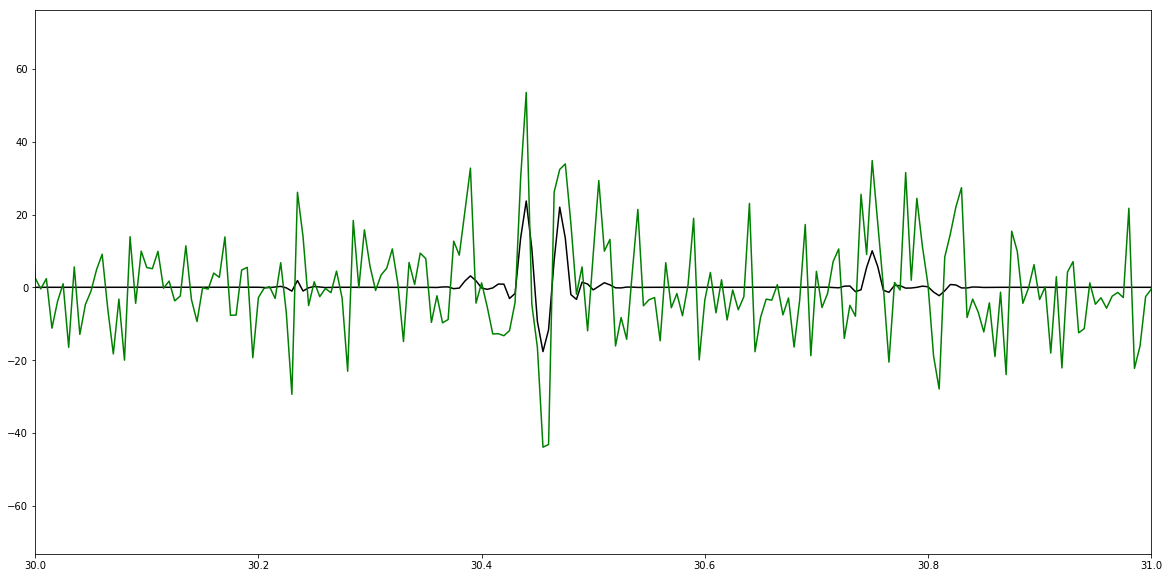

In [173]:
# Plot
plt.figure(figsize=(20,10))
plt.plot(time, renc, 'black')
plt.plot(time, accZ, 'green')
plt.xlim([30,31])


In [ ]:
rawsig = (accZ-np.mean(accZ))[2000:14000]
fs = 200
lf = 40/60 #bmp to Hz
hf = 140/60 

In [112]:
def fftfilt(x,lf,hf,fs):
    X = np.fft.rfft(x)
    f = np.fft.rfftfreq(len(x),1/fs)
    X_filt = np.array([X[i] if (f[i] >= lf and f[i] <= hf) else 0 for i in range(0,len(X))])
    x_filt = np.fft.irfft(X_filt)
    return x_filt

def butterfilt(x, lf, hf, fs):
    b,a = butter(3,[lf,hf], btype='bandpass', fs=fs)
    x_filt = filtfilt(b,a, x)  
    return x_filt 


In [ ]:
# prove
sig_filt_fft = fftfilt(rawsig,lf,hf,fs)
sig_filt_butter = butterfilt(rawsig,lf,hf,fs)

#cerco i picchi (battiti) 
peaks_fft,_ = find_peaks(sig_filt_fft, height=0.2, threshold=None, distance=fs/hf, prominence=0.4, width=None, wlen=None, rel_height=0.5, plateau_size=None)
peaks_butt,_ = find_peaks(sig_filt_butter, height=0.2, threshold=None, distance=fs/hf, prominence=0.4, width=None, wlen=None, rel_height=0.5, plateau_size=None)
print("mean BPM with FFT filt= ",len(peaks_fft)*60/(len(sig_filt_fft)/fs))
print("mean BPM with butterworth filt= ",len(peaks_butt)*60/(len(sig_filt_butter)/fs))

**Metrics:**

1. Heart Beat Per Minute(BPM): extrapolate BPM, make an histogram of the result. Does it follow a partiular distribution? 
    

2. Heart Rate Variability(HRV): extrapolate HRV, explain why this parameter is important, and plot the results.

**Optional Algorithm:** 

Elaborate a simple algorithm to extrapolate heart beat even when filter failed (e.g. look at particular threshold...).  

**Conclusion:**

Summarise the obtained results, in particular making a comparison between the two files analysed. Highlight limitation and critical issues encountered during the work, motivating the most relevant contribution given by your solution.

